In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import lab2rgb
import sys

from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [11]:
OUTPUT_TEMPLATE = (
    'Bayesian classifier: {bayes_rgb:.3g} {bayes_lab:.3g}\n'
    'kNN classifier:      {knn_rgb:.3g} {knn_lab:.3g}\n'
    'SVM classifier:      {svm_rgb:.3g} {svm_lab:.3g}\n'
)


# representative RGB colours for each label, for nice display
COLOUR_RGB = {
    'red': (255, 0, 0),
    'orange': (255, 114, 0),
    'yellow': (255, 255, 0),
    'green': (0, 230, 0),
    'blue': (0, 0, 255),
    'purple': (187, 0, 187),
    'brown': (117, 60, 0),
    'pink': (255, 187, 187),
    'black': (0, 0, 0),
    'grey': (150, 150, 150),
    'white': (255, 255, 255),
}
name_to_rgb = np.vectorize(COLOUR_RGB.get, otypes=[np.uint8, np.uint8, np.uint8])

In [12]:

def plot_predictions(model, lum=71, resolution=256):
    """
    Create a slice of LAB colour space with given luminance; predict with the model; plot the results.
    """
    wid = resolution
    hei = resolution
    n_ticks = 5

    # create a hei*wid grid of LAB colour values, with L=lum
    ag = np.linspace(-100, 100, wid)
    bg = np.linspace(-100, 100, hei)
    aa, bb = np.meshgrid(ag, bg)
    ll = lum * np.ones((hei, wid))
    lab_grid = np.stack([ll, aa, bb], axis=2)

    # convert to RGB for consistency with original input
    X_grid = lab2rgb(lab_grid)

    # predict and convert predictions to colours so we can see what's happening
    y_grid = model.predict(X_grid.reshape((wid*hei, 3)))
    pixels = np.stack(name_to_rgb(y_grid), axis=1) / 255
    pixels = pixels.reshape((hei, wid, 3))

    # plot input and predictions
    plt.figure(figsize=(10, 5))
    plt.suptitle('Predictions at L=%g' % (lum,))
    plt.subplot(1, 2, 1)
    plt.title('Inputs')
    plt.xticks(np.linspace(0, wid, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.yticks(np.linspace(0, hei, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.xlabel('A')
    plt.ylabel('B')
    plt.imshow(X_grid.reshape((hei, wid, 3)))

    plt.subplot(1, 2, 2)
    plt.title('Predicted Labels')
    plt.xticks(np.linspace(0, wid, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.yticks(np.linspace(0, hei, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.xlabel('A')
    plt.imshow(pixels)

In [13]:
def rgb_to_leg_converter(rgb_color):
    import skimage.color as skc
    print (rgb_color.shape)
    r1 = rgb_color.reshape((-1, 1, 3))
    print(r1.shape) 
    print(r1) 
    lab_colours = skc.rgb2lab(r1)
    return lab_colours.reshape(-1, 3)

(2962, 3)
(2962, 1, 3)
[[[0.62352941 0.51764706 0.2627451 ]]

 [[0.56862745 0.36078431 0.92941176]]

 [[0.90980392 0.96078431 0.87058824]]

 ...

 [[0.22745098 0.01176471 0.20784314]]

 [[0.31764706 0.15686275 0.05098039]]

 [[0.18039216 0.90588235 0.45098039]]]
(65536, 3)
(65536, 1, 3)
[[[0.         0.86851198 1.        ]]

 [[0.         0.86781506 1.        ]]

 [[0.         0.86711342 1.        ]]

 ...

 [[1.         0.10039897 0.        ]]

 [[1.         0.07181505 0.        ]]

 [[1.         0.0295284  0.        ]]]
(2962, 3)
(2962, 1, 3)
[[[0.62352941 0.51764706 0.2627451 ]]

 [[0.56862745 0.36078431 0.92941176]]

 [[0.90980392 0.96078431 0.87058824]]

 ...

 [[0.22745098 0.01176471 0.20784314]]

 [[0.31764706 0.15686275 0.05098039]]

 [[0.18039216 0.90588235 0.45098039]]]
(65536, 3)
(65536, 1, 3)
[[[0.         0.86851198 1.        ]]

 [[0.         0.86781506 1.        ]]

 [[0.         0.86711342 1.        ]]

 ...

 [[1.         0.10039897 0.        ]]

 [[1.         0.071815

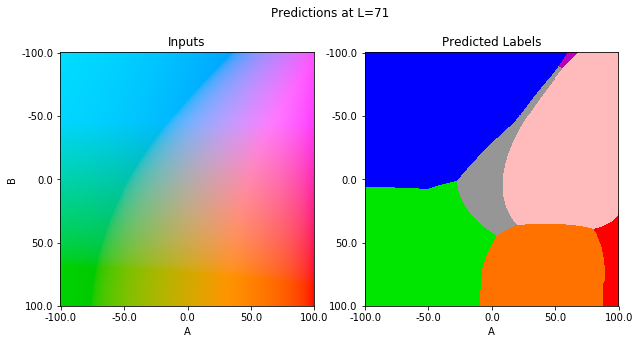

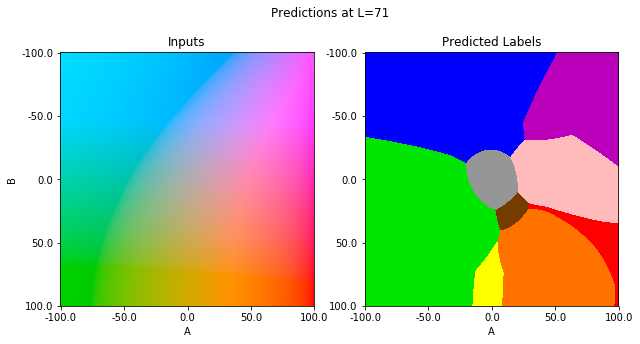

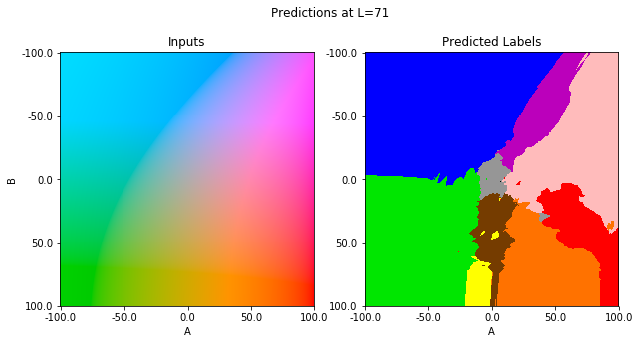

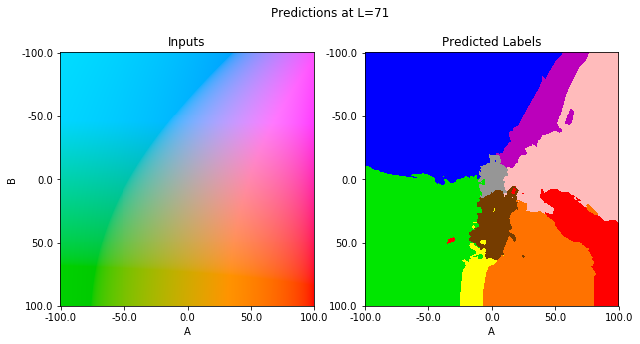

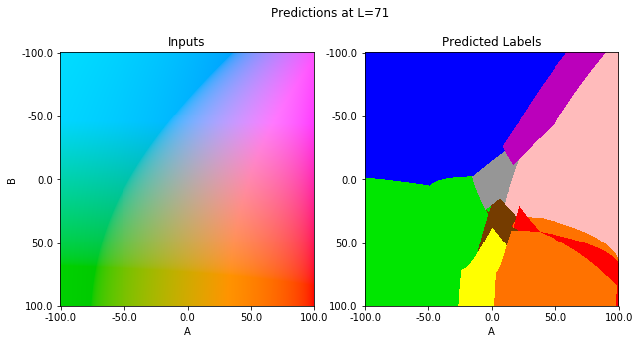

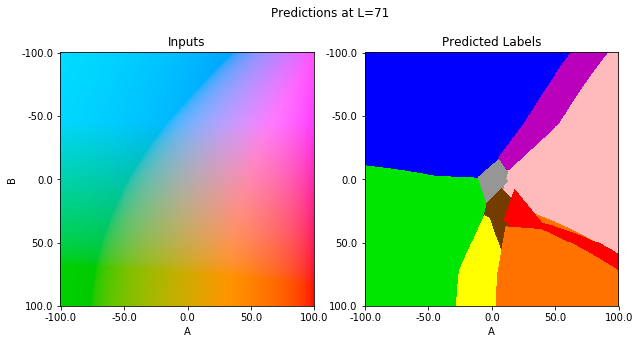

In [14]:
def main():
    file = 'colour-data.csv';
    data = pd.read_csv(file)
    #data = pd.read_csv(sys.argv[1])
    X = data[['R', 'G', 'B']].values / 255
    y = data['Label'].values

    # TODO: create some models
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    
    bayes_rgb_model = GaussianNB()
    bayes_lab_model = make_pipeline(
        FunctionTransformer(rgb_to_leg_converter),
        GaussianNB()
    )
    
    knn_rgb_model = KNeighborsClassifier(n_neighbors=5)
    
    knn_lab_model = make_pipeline(
        FunctionTransformer(rgb_to_leg_converter),
        KNeighborsClassifier(n_neighbors=5)
    )
    
    svc_rgb_model = SVC(kernel='linear', decision_function_shape='ovr')
    
    svc_lab_model = make_pipeline(
        FunctionTransformer(rgb_to_leg_converter),
        SVC(kernel='linear', decision_function_shape='ovr')
    )

    # train each model and output image of predictions
    models = [bayes_rgb_model, bayes_lab_model, knn_rgb_model, knn_lab_model, svc_rgb_model, svc_lab_model]
    for i, m in enumerate(models):  # yes, you can leave this loop in if you want.
        m.fit(X_train, y_train)
        plot_predictions(m)
        plt.savefig('predictions-%i.png' % (i,))

    print(OUTPUT_TEMPLATE.format(
        bayes_rgb=bayes_rgb_model.score(X_test, y_test),
        bayes_lab=bayes_lab_model.score(X_test, y_test),
        knn_rgb=knn_rgb_model.score(X_test, y_test),
        knn_lab=knn_lab_model.score(X_test, y_test),
        svm_rgb=svc_rgb_model.score(X_test, y_test),
        svm_lab=svc_lab_model.score(X_test, y_test),
    ))


if __name__ == '__main__':
    main()

In [15]:
a = np.array( [[1, 2, 3],
              [1, 2, 3]])

In [16]:
a.shape

(2, 3)

In [17]:
a.shape

(2, 3)

In [18]:
a.reshape(1, 3)

ValueError: cannot reshape array of size 6 into shape (1,3)